In [1]:
!git clone https://github.com/NVlabs/stylegan3.git

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 34.45 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
%cd stylegan3

/content/stylegan3


In [3]:
!pip install Ninja -q
!pip install imageio-ffmpeg -q
!pip install youtube-dl -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.9 MB/s eta 0:00:00


In [4]:
import torch
import dnnlib
import legacy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
#!pip install torch==1.13.1

In [5]:
# https://github.com/NVlabs/ffhq-dataset
base_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/'
model = "stylegan3-r-ffhq-1024x1024.pkl"
url = base_url + model
print(url)

https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl


In [6]:
seed = 500
!python gen_images.py --network=$url --trunc=1 --seeds=$seed --outdir=/content/results

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Generating image for seed 500 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


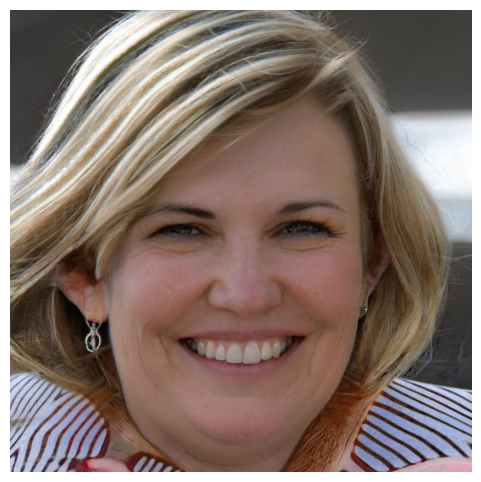

In [7]:
image = Image.open('/content/results/seed%04d.png' % seed)
plt.figure(figsize = (6,6))
plt.axis('off')
plt.imshow(image)

In [8]:
!python gen_images.py --network={url} --outdir=/content/results --seeds=500-505

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Generating image for seed 500 (0/6) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for seed 501 (1/6) ...
Generating image for seed 502 (2/6) ...
Generating image for seed 503 (3/6) ...
Generating image for seed 504 (4/6) ...
Generating image for seed 505 (5/6) ...


In [9]:
seed_start = 500
seed_end = 505

for n_seed in range(seed_start, seed_end + 1):
  #print(n_seed)
  image = Image.open('/content/results/seed%04d.png' % n_seed)
  plt.figure(figsize = (6,6))
  plt.axis('off')
  plt.imshow(image)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
device = torch.device('cuda')
def load_network(url, device):
  with dnnlib.util.open_url(url) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)
  return G

In [11]:
G = load_network(url, device)

In [12]:
def generate_z(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

In [13]:
seed = np.random.randint(10000000)
print(seed)
z = generate_z(G, seed)
print(z.shape)

720374
(1, 512)


In [14]:
def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = torch.zeros([1, G.c_dim], device=device)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  # (1, 3, 1024, 1024) -> (1024, 1024, 3)
  img = (img.permute(0,2,3,1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [15]:
def show_img(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

Seed: 800
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


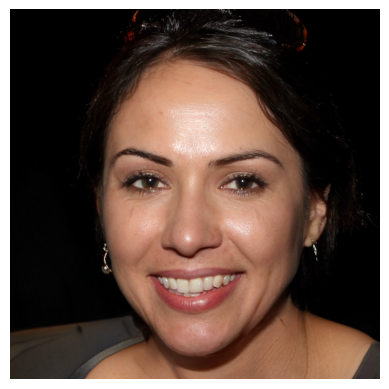

In [16]:
seed = 800
print('Seed:', seed)
z = generate_z(G, seed)
img = generate_image(device, G, z)
show_img(img)

Seed:  4210


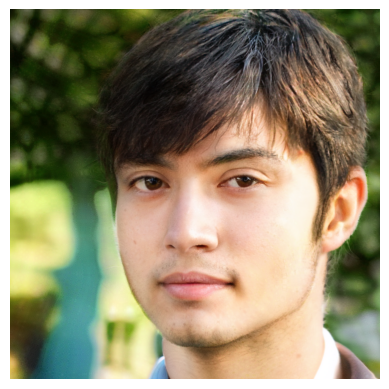

Seed:  4262


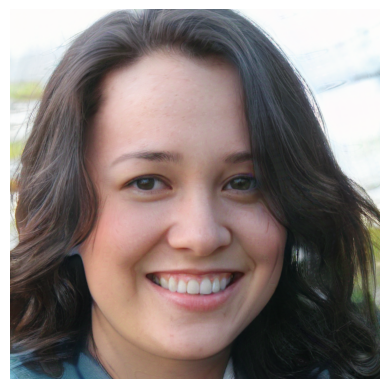

Seed:  4295


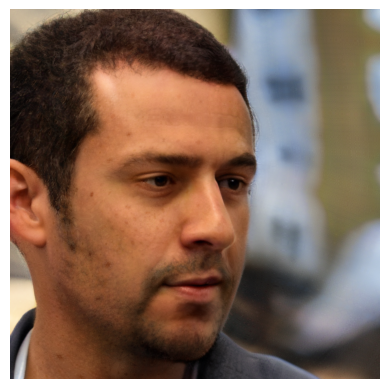

Seed:  4218


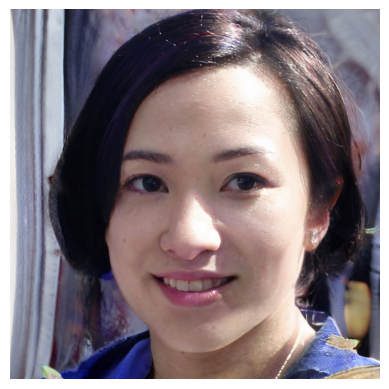

Seed:  500


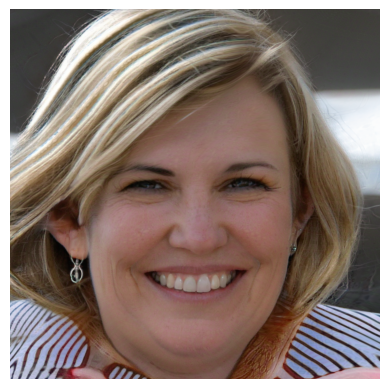

Seed:  800


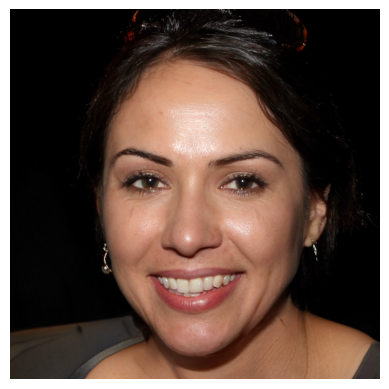

In [17]:
seed_list = [4210, 4262, 4295, 4218, 500, 800]

for s in seed_list:
  print('Seed: ', s)
  z = generate_z(G, s)
  img = generate_image(device, G, z)
  show_img(img)

In [18]:
seed_start = 4210
seed_end = 4216
custom_truncation = 0.1

for s in range(seed_start, seed_end+1):
  plt.figure(figsize=(10,6))
  print('Seed: ', seed)
  z = generate_z(G, s)

  image = generate_image(device, G, z)
  image2 = generate_image(device, G, z, custom_truncation)
  plt.subplot(1,2,1)
  plt.title('Truncation = 1')
  plt.imshow(image)

  plt.subplot(1,2,2)
  plt.title('Truncation = {}'.format(custom_truncation))
  plt.imshow(image2)

  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [19]:
from tqdm.notebook import tqdm as log_progress

In [20]:
os.makedirs('/content/interpolation/', exist_ok = True)

In [21]:
seeds = [4210, 4262]
num_vectors = 10

def interpolation(seeds, num_vectors, truncation = 1):
  interpolation_images = []

  idx = 0
  for i in range(len(seeds) - 1):
    latent1 = generate_z(G, seeds[i])
    latent2 = generate_z(G, seeds[i + 1])

    difference = latent2 - latent1
    step = difference / num_vectors
    current = latent1.copy()

    for j in log_progress(range(num_vectors), desc=f'Seed {seeds[i]}'):
      current = current + step
      image = generate_image(device, G, current, truncation)
      interpolation_images.append(image)
      image.save(f'/content/interpolation/frame-{idx}.png')
      idx += 1
  return interpolation_images

In [22]:
interpolation_images = interpolation(seeds, num_vectors, 0.7)

Seed 4210:   0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
from math import ceil
from google.colab.patches import cv2_imshow

def show_images_grid(images, scale=0.25, lines=1):
   w, h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = lines*h
   cols = ceil(len(images) / lines)
   width = cols*w
   grid = Image.new('RGBA', (width,height), 'white')
   for i, img in enumerate(images):
     img = img.resize((w,h), Image.ANTIALIAS)
     grid.paste(img, (w*(i % cols), h*(i // cols)))

   grid = np.array(grid)
   return grid

def show_full_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return cv2_imshow(image)

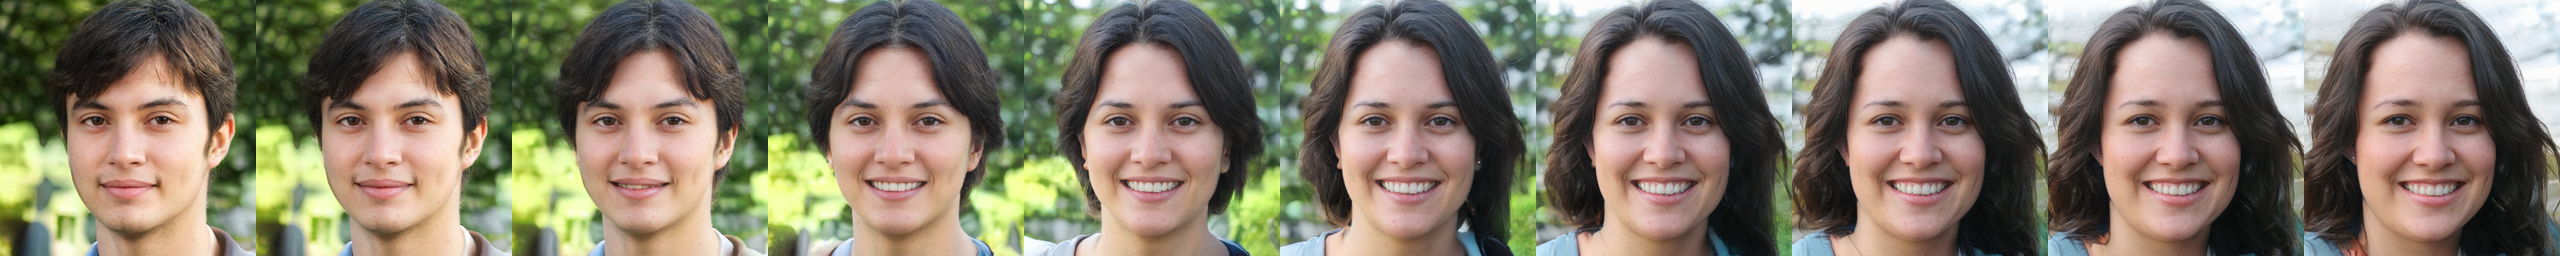

In [24]:
grid_images = show_images_grid(interpolation_images)
show_full_image(grid_images)

In [25]:
import imageio
from IPython.display import Image as displayImage

def create_gif(output_file, images_interpolation):
  with imageio.get_writer(output_file, mode='I', duration=0.15) as writer:

    for i, image in enumerate(images_interpolation):
      frame_anim = np.array(image)
      frame_anim = cv2.resize(frame_anim, (300,300))
      writer.append_data(frame_anim)

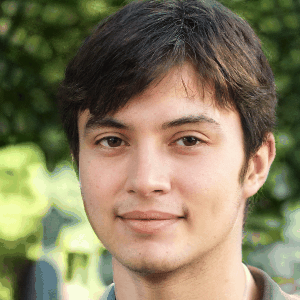

In [26]:
output_file = 'animination.gif'
create_gif(output_file, interpolation_images)
displayImage(open(output_file, 'rb').read())

In [27]:
model = 'stylegan3-r-metfacesu-1024x1024.pkl'
url = base_url + model

seed_start = 1010
seed_end = 1020

G = load_network(url, device)

for s in range(seed_start, seed_end+1):
  print(f"Seed: {s}")
  z = generate_z(G, s)
  img = generate_image(device, G, z, 0.7)
  show_img(img)

Output hidden; open in https://colab.research.google.com to view.

Seed 1015:   0%|          | 0/10 [00:00<?, ?it/s]

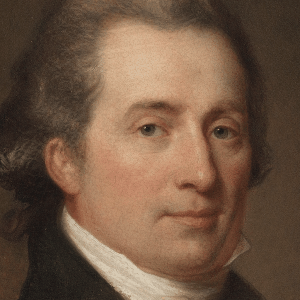

In [28]:
seeds = [1015, 1010]
num_vectors = 10

interpolation_images = interpolation(seeds, num_vectors, 0.5)

output_file = 'animation_metfaces.gif'
create_gif(output_file, interpolation_images)
displayImage(open(output_file,'rb').read())

In [29]:
model = 'stylegan3-t-afhqv2-512x512.pkl'
url = base_url + model

seed_start = 4210
seed_end = 4220

G = load_network(url, device)

for s in range(seed_start, seed_end+1):
  print(f"Seed: {s}")
  z = generate_z(G, s)
  img = generate_image(device, G, z, 0.7)
  show_img(img)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
seeds = [4220, 4211]
num_vectors = 20

interpolation_images = interpolation(seeds, num_vectors, 0.5)

output_file = 'animation_afhqv2.gif'
create_gif(output_file, interpolation_images)
displayImage(open(output_file,'rb').read())

Output hidden; open in https://colab.research.google.com to view.